In [1]:
# Install required libraries
!pip install -q timm datasets

# Import necessary modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from datasets import load_dataset
import timm

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

# Set up device (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Configuration ---
NUM_CLASSES = 20
BATCH_SIZE = 64
IMG_SIZE = 224

# --- Load, Filter, and Prepare Dataset ---
# (This code is the same as before)
print("Loading and preparing the dataset...")
full_dataset = load_dataset("Maysee/tiny-imagenet", split='train')
all_class_names = full_dataset.features['label'].names
selected_class_names = all_class_names[:NUM_CLASSES]
class_to_idx = {name: i for i, name in enumerate(selected_class_names)}
original_class_indices = [all_class_names.index(name) for name in selected_class_names]

def filter_by_class(example):
    return example['label'] in original_class_indices
filtered_dataset = full_dataset.filter(filter_by_class)

def remap_labels(example):
    original_label_name = all_class_names[example['label']]
    example['label'] = class_to_idx[original_label_name]
    return example
remapped_dataset = filtered_dataset.map(remap_labels)

dataset_splits = remapped_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_splits['train']
val_dataset = dataset_splits['test']

data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def apply_transform(examples):
    examples['pixel_values'] = [data_transform(image.convert("RGB")) for image in examples['image']]
    return examples

train_dataset.set_transform(apply_transform)
val_dataset.set_transform(apply_transform)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print("\nDataLoaders created successfully. Ready for training.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.5 MB/s eta 0:00:00
Using device: cuda
Loading and preparing the dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

(…)-00000-of-00001-1359597a978bc4fa.parquet:   0%|          | 0.00/146M [00:00<?, ?B/s]

(…)-00000-of-00001-70d52db3c749a935.parquet:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]


DataLoaders created successfully. Ready for training.


In [2]:
# Note: The embedding dimension for 'vit_tiny' is 192.
# The number of heads must be a divisor of 192.
# We will compare 3, 6, and 12 heads.

# Model 1: ViT with 3 Attention Heads
vit_3_heads = timm.create_model(
    'vit_tiny_patch16_224',
    pretrained=False, # Must train from scratch
    num_classes=NUM_CLASSES,
    num_heads=3
).to(device)

# Model 2: ViT with 6 Attention Heads
vit_6_heads = timm.create_model(
    'vit_tiny_patch16_224',
    pretrained=False,
    num_classes=NUM_CLASSES,
    num_heads=6
).to(device)

# Model 3: ViT with 12 Attention Heads (the default for vit_tiny)
vit_12_heads = timm.create_model(
    'vit_tiny_patch16_224',
    pretrained=False,
    num_classes=NUM_CLASSES,
    num_heads=12
).to(device)

print("--- ViT Models with Varying Heads Created ---")
print(f"Model 1 Heads: {vit_3_heads.blocks[0].attn.num_heads}")
print(f"Model 2 Heads: {vit_6_heads.blocks[0].attn.num_heads}")
print(f"Model 3 Heads: {vit_12_heads.blocks[0].attn.num_heads}")

--- ViT Models with Varying Heads Created ---
Model 1 Heads: 3
Model 2 Heads: 6
Model 3 Heads: 12



--- Training ViT (3 Heads) for 5 epochs ---


Epoch 1/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/5 | Validation Acc: 21.75%


Epoch 2/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/5 | Validation Acc: 26.30%


Epoch 3/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/5 | Validation Acc: 31.55%


Epoch 4/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/5 | Validation Acc: 29.50%


Epoch 5/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/5 | Validation Acc: 33.70%

Finished Training ViT (3 Heads). Best Validation Accuracy: 33.70%

--- Training ViT (6 Heads) for 5 epochs ---


Epoch 1/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/5 | Validation Acc: 20.10%


Epoch 2/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/5 | Validation Acc: 24.80%


Epoch 3/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/5 | Validation Acc: 27.75%


Epoch 4/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/5 | Validation Acc: 33.20%


Epoch 5/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/5 | Validation Acc: 33.50%

Finished Training ViT (6 Heads). Best Validation Accuracy: 33.50%

--- Training ViT (12 Heads) for 5 epochs ---


Epoch 1/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/5 | Validation Acc: 19.10%


Epoch 2/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/5 | Validation Acc: 27.95%


Epoch 3/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/5 | Validation Acc: 29.80%


Epoch 4/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/5 | Validation Acc: 34.80%


Epoch 5/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/5 | Validation Acc: 35.80%

Finished Training ViT (12 Heads). Best Validation Accuracy: 35.80%


================= FINAL RESULTS =================

Model Configuration       | Final Validation Accuracy (%) 
------------------------------------------------------------
ViT (3 Heads)             | 33.70
ViT (6 Heads)             | 33.50
ViT (12 Heads)            | 35.80


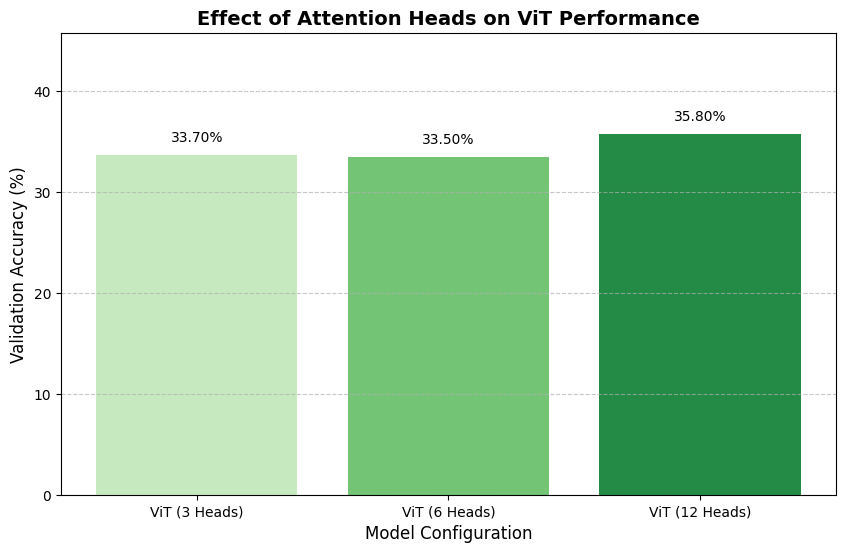

In [3]:
def train_model(model, model_name, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"\n--- Training {model_name} for {epochs} epochs ---")

    best_val_acc = 0.0

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            inputs = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # --- Validation Phase ---
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['pixel_values'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        print(f"Epoch {epoch+1}/{epochs} | Validation Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    print(f"\nFinished Training {model_name}. Best Validation Accuracy: {best_val_acc:.2f}%")
    return best_val_acc

# --- Execution ---
EPOCHS = 5 # Training from scratch requires a bit more training
results = {}

# Train each model
acc_3_heads = train_model(vit_3_heads, "ViT (3 Heads)", train_loader, val_loader, epochs=EPOCHS)
results['ViT (3 Heads)'] = acc_3_heads

acc_6_heads = train_model(vit_6_heads, "ViT (6 Heads)", train_loader, val_loader, epochs=EPOCHS)
results['ViT (6 Heads)'] = acc_6_heads

acc_12_heads = train_model(vit_12_heads, "ViT (12 Heads)", train_loader, val_loader, epochs=EPOCHS)
results['ViT (12 Heads)'] = acc_12_heads

# --- Final Comparison ---
print("\n\n================= FINAL RESULTS =================\n")
print(f"{'Model Configuration':<25} | {'Final Validation Accuracy (%)':<30}")
print("-" * 60)
for model_name, acc in results.items():
    print(f"{model_name:<25} | {acc:.2f}")

# --- Plotting the results ---
model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['#c7e9c0', '#74c476', '#238b45'])
plt.xlabel("Model Configuration", fontsize=12)
plt.ylabel("Validation Accuracy (%)", fontsize=12)
plt.title("Effect of Attention Heads on ViT Performance", fontsize=14, weight='bold')
plt.ylim(0, max(accuracies) + 10) # Adjust ylim for better viewing
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.show()